In [1]:
# LIST OF UPDATES
#
# Added bias (constant) to each linear layer
# Switched to using equivalent keras optimizer - SGD 
# Moved loss calculation to an independent function
# Switched to defining the network as Keras layers(!)
# Add tf.function to training loop - 10x speed increase(!)
# Switch to calculating gradients with keras 'trainable_weight' vs tf 'variables' 
# Tried using Keras Model.fit but order of magnitude slower than custom loop!
# Switch to train/val/test -> Showed that validation accuracy peaks at about 55% Training accuracy :(
# Switch to MeanSquaredError as loss function (But this is not a good error for classification)
# Add callback support to custom training loop
# Early completion based on validation changes
# Switch to correct method of regularisation with L2 Loss
# Addition of Dropout for regularisation
# Batch support (improves regularisation)
# Tried various train/test/val combinations - results are very sensitive to this.
# Tried various activation functions - "elu" seems best (not sure why yet)
# Switched to BinaryCrossEntropy loss function from keras
# Switched to Adam optimiser with scheduled learning
# Utilised log x-scale to compare model plot results
# TODO : Represent data using windowing method

In [35]:
import tensorflow as tf
import tensorflow.compat.v1 as tf1

import numpy as np
import pandas as pd

import quantutils.dataset.pipeline as ppl
import quantutils.dataset.ml as mlutils
from marketinsights.api.model import MarketInsightsModel
from marketinsights.remote.ml import MIAssembly

from tqdm import tqdm, trange
from functools import partialmethod

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from  IPython import display
from matplotlib import pyplot as plt


tqdm.__init__ = partialmethod(tqdm.__init__, disable=False)

In [89]:
#DATASET_ID1 = "dbaab93d94795145539e595fab79f2d4"  # DOW
DATASET_ID1 = "4234f0f1b6fcc17f6458696a6cdf5101"  # DOW
NUM_FEATURES = (2 * 4) + 1

assembly = MIAssembly(secret="marketinsights-k8s-cred")

# Dataset
dataset, descriptor = assembly.get_dataset_by_id(DATASET_ID1, debug=False)
dataset.info()
dataset = tf.cast(dataset, tf.float32)

# Split into Train/Val/Test
n = len(dataset)
train_df = dataset[:1200]
val_df = dataset[1200:1300]
test_df = dataset[1300:]

# Split into features/labels
train_x, train_y = train_df[:, :NUM_FEATURES], train_df[:,NUM_FEATURES:]
val_x, val_y =  val_df[:, :NUM_FEATURES], val_df[:,NUM_FEATURES:]
test_x, test_y =  test_df[:, :NUM_FEATURES], test_df[:,NUM_FEATURES:]


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1377 entries, 2013-01-02 15:00:00-05:00 to 2018-08-01 15:00:00-04:00
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1377 non-null   float64
 1   1       1377 non-null   float64
 2   2       1377 non-null   float64
 3   3       1377 non-null   float64
 4   4       1377 non-null   float64
 5   5       1377 non-null   float64
 6   6       1377 non-null   float64
 7   7       1377 non-null   float64
 8   8       1377 non-null   float64
 9   9       1377 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 118.3 KB


In [61]:

def batches(x, y, batch_size):
    return [(batch, x[batch*batch_size:(batch+1)*batch_size], y[batch*batch_size:(batch+1)*batch_size]) for batch in range(int(len(x) / batch_size))]


def train(mlmodel, epochs=100000, _callbacks=[]):
    
    callbacks = tf.keras.callbacks.CallbackList(_callbacks, add_history=True, model=mlmodel)
    
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      0.001,
      decay_steps=1000,
      decay_rate=1,
      staircase=False)

    optimizer = tf.keras.optimizers.Adam(lr_schedule)
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    
    @tf.function  # Make it fast.
    def train_on_batch(x, y):
        with tf.GradientTape() as tape:
            binary_cross_entropy = loss_fn(y_pred=mlmodel(x, training=True), y_true=y, ) 
            regularization_loss=tf.add_n(mlmodel.losses)
            val_binary_cross_entropy = loss_fn(y_pred=mlmodel(val_x), y_true=val_y)
            val_loss = val_binary_cross_entropy
            loss = binary_cross_entropy + regularization_loss
            gradients = tape.gradient(loss, mlmodel.trainable_weights)
        optimizer.apply_gradients(zip(gradients, mlmodel.trainable_weights))
        return {"loss":loss, "val_loss": val_loss, "binary_cross_entropy":binary_cross_entropy, "val_binary_cross_entropy":val_binary_cross_entropy, "regularization_loss":regularization_loss}


    logs = {}
    mlmodel.stop_training = False

    
    callbacks.on_train_begin(logs=logs)

    # Format training loop
    for epoch in range(epochs):

        callbacks.on_epoch_begin(epoch, logs=logs)
        #mlmodel.reset_states() # Not needed?

        for batch, batch_x, batch_y in batches(train_x, train_y, 400):

            callbacks.on_batch_begin(batch, logs=logs)
            callbacks.on_train_batch_begin(batch, logs=logs)

            logs = train_on_batch(batch_x, batch_y)

            callbacks.on_train_batch_end(batch, logs=logs)
            callbacks.on_batch_end(batch, logs=logs)

        callbacks.on_epoch_end(epoch, logs=logs)

        if epoch % 1000 == 0:
            print(f'Step {epoch} - Training Loss: {logs["loss"]}, Val Loss: {logs["val_loss"]}')

        if mlmodel.stop_training:
            print(f'Step {epoch} - Training Loss: {logs["loss"]}, Val Loss: {logs["val_loss"]}')
            break

    callbacks.on_train_end(logs=logs)

    # Fetch the history object we normally get from keras.fit
    history_object = None
    for cb in callbacks:
        if isinstance(cb, tf.keras.callbacks.History):
            history_object = cb
    assert history_object is not None
    
    return history_object

In [92]:
TOTAL_EPOCHS = 150000

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_binary_cross_entropy', mode='min', verbose=1, start_from_epoch=1000, patience=10000, restore_best_weights=True)
# Set up callbacks
callbacks = []


In [ ]:
histories = {}

In [ ]:
NUM_LABELS = 1
HIDDEN_UNITS = 64

# Prepare our layer, loss, and optimizer.
mlmodel = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="elu"),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="elu"),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="elu"),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="elu"),
        #tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_LABELS),
    ]
)

histories["64x4"] = train(mlmodel, TOTAL_EPOCHS, callbacks)

In [95]:
NUM_LABELS = 1
HIDDEN_UNITS = 64

# Prepare our layer, loss, and optimizer.
mlmodel = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="elu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="elu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="elu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="elu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_LABELS),
    ]
)

histories["64x4+DO"] = train(mlmodel, TOTAL_EPOCHS, callbacks)

Step 0 - Training Loss: 0.9561123847961426, Val Loss: 0.7033458948135376
Step 1000 - Training Loss: 0.6914803981781006, Val Loss: 0.7057530879974365
Step 2000 - Training Loss: 0.6891158819198608, Val Loss: 0.7062280178070068
Step 3000 - Training Loss: 0.6903319358825684, Val Loss: 0.706481397151947
Step 4000 - Training Loss: 0.6863484382629395, Val Loss: 0.7068092226982117
Step 5000 - Training Loss: 0.6851012110710144, Val Loss: 0.7070695757865906
Step 6000 - Training Loss: 0.6859199404716492, Val Loss: 0.7072293758392334
Step 7000 - Training Loss: 0.6876549124717712, Val Loss: 0.7067835330963135
Step 8000 - Training Loss: 0.6847488284111023, Val Loss: 0.7071772217750549
Step 9000 - Training Loss: 0.6873933672904968, Val Loss: 0.7072721123695374
Step 10000 - Training Loss: 0.6878080368041992, Val Loss: 0.7076188921928406
Step 11000 - Training Loss: 0.6874042749404907, Val Loss: 0.707194983959198
Step 12000 - Training Loss: 0.6888116598129272, Val Loss: 0.7075088620185852
Step 13000 - T

Step 107000 - Training Loss: 0.6844136714935303, Val Loss: 0.7078345417976379
Step 108000 - Training Loss: 0.6860133409500122, Val Loss: 0.7078819274902344
Step 109000 - Training Loss: 0.6855311989784241, Val Loss: 0.707886815071106
Step 110000 - Training Loss: 0.6845839619636536, Val Loss: 0.7078683972358704
Step 111000 - Training Loss: 0.6858935356140137, Val Loss: 0.7079689502716064
Step 112000 - Training Loss: 0.6851781010627747, Val Loss: 0.7079836130142212
Step 113000 - Training Loss: 0.684616208076477, Val Loss: 0.7080312371253967
Step 114000 - Training Loss: 0.6836063265800476, Val Loss: 0.7079359292984009
Step 115000 - Training Loss: 0.6848289966583252, Val Loss: 0.7079208493232727
Step 116000 - Training Loss: 0.6849303245544434, Val Loss: 0.7078567743301392
Step 117000 - Training Loss: 0.6851227283477783, Val Loss: 0.7078945636749268
Step 118000 - Training Loss: 0.6835383176803589, Val Loss: 0.7078499794006348
Step 119000 - Training Loss: 0.6847920417785645, Val Loss: 0.70792

Text(0.5, 0, 'Epochs')

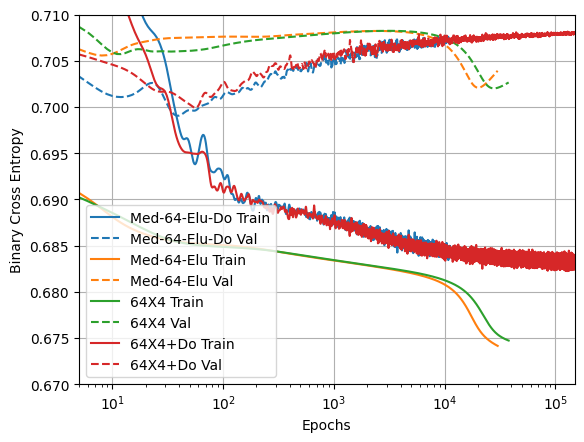

In [96]:
# PLOT histories
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_cross_entropy', smoothing_std=10)
plotter.plot(histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.670, 0.71])
plt.xlabel("Epochs")

Text(0.5, 0, 'Epochs')

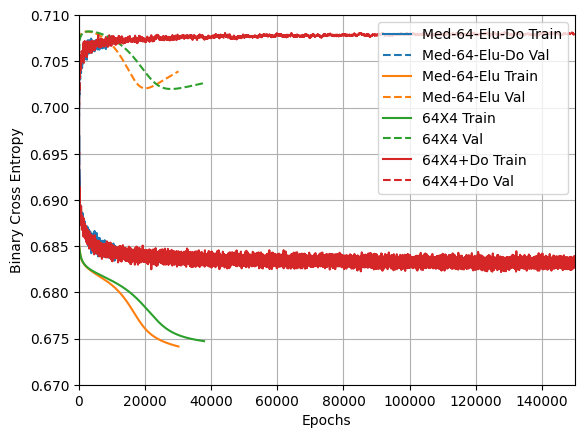

In [97]:
# PLOT histories
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_cross_entropy', smoothing_std=10)
plotter.plot(histories)
#a = plt.xscale('log')
#plt.xlim([5, max(plt.xlim())])
plt.ylim([0.670, 0.71])
plt.xlabel("Epochs")

Text(0.5, 0, 'Epochs [Log Scale]')

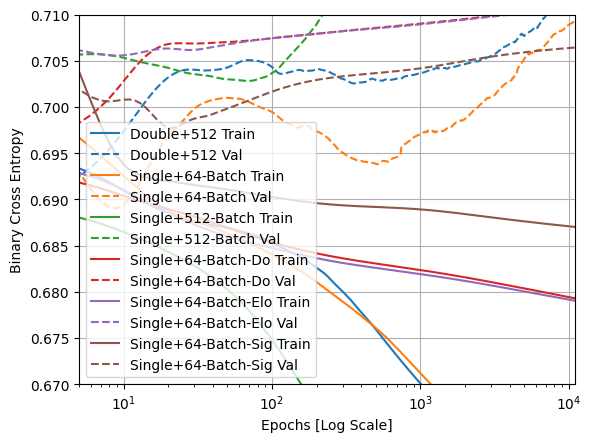

In [321]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from  IPython import display
from matplotlib import pyplot as plt

#histories = {}
histories['Single+64-batch-sig'] = history_object

plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_cross_entropy', smoothing_std=10)
plotter.plot(histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.670, 0.71])
plt.xlabel("Epochs [Log Scale]")

Text(0.5, 0, 'Epochs [Log Scale]')

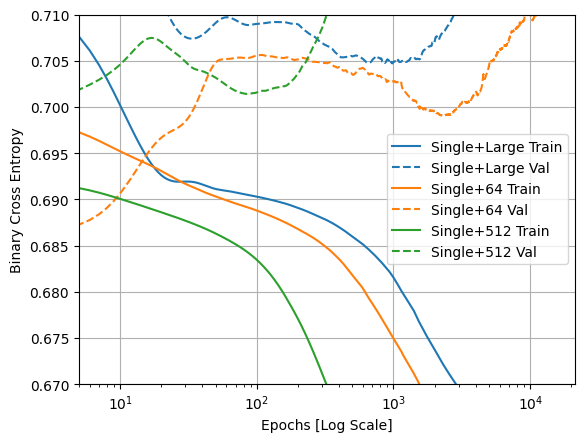

In [273]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from  IPython import display
from matplotlib import pyplot as plt

#histories = {}
histories['Single+512'] = history_object

plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_cross_entropy', smoothing_std=10)
plotter.plot(histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.670, 0.71])
plt.xlabel("Epochs [Log Scale]")

In [66]:
history_object.history["val_loss"][-10:]

[0.7039121985435486,
 0.7039124369621277,
 0.7039126753807068,
 0.7039129137992859,
 0.7039129734039307,
 0.7039132118225098,
 0.7039134502410889,
 0.7039136290550232,
 0.7039138674736023,
 0.7039140462875366]

In [353]:
min(history_object.history["val_loss"])

0.6986668109893799

In [67]:
mlutils.evaluate(ppl.onehot(tf.nn.sigmoid(mlmodel(train_x)).numpy()), ppl.onehot(train_y.numpy()), threshold=0.5)

Won : 671.0
Lost : 529.0
Total : 1200.0
Diff : 142.0
Edge : 11.833333333333334%
Information Coefficient : 0.11833333969116211


0.55916667

In [68]:
mlutils.evaluate(ppl.onehot(tf.nn.sigmoid(mlmodel(val_x)).numpy()), ppl.onehot(val_y.numpy()), threshold=0.5)

Won : 48.0
Lost : 52.0
Total : 100.0
Diff : -4.0
Edge : -4.0%
Information Coefficient : -0.04000002145767212


0.48

In [69]:
mlutils.evaluate(ppl.onehot(np.round(tf.nn.sigmoid(mlmodel(test_x)).numpy())), ppl.onehot(test_y.numpy()), threshold=.50)

Won : 43.0
Lost : 34.0
Total : 77.0
Diff : 9.0
Edge : 11.688311688311689%
Information Coefficient : 0.11688315868377686


0.5584416

In [74]:
tf.keras.losses.BinaryCrossentropy(from_logits=True)(y_pred=mlmodel(val_x), y_true=val_y)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7020023>